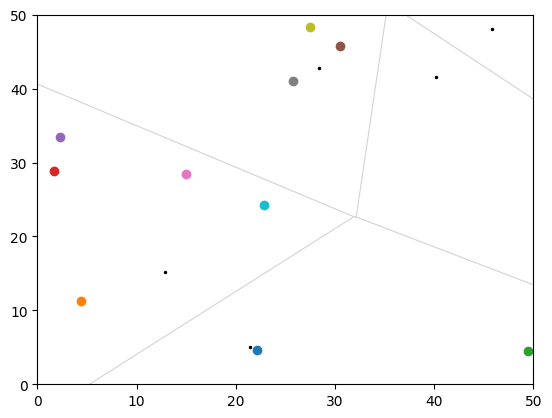

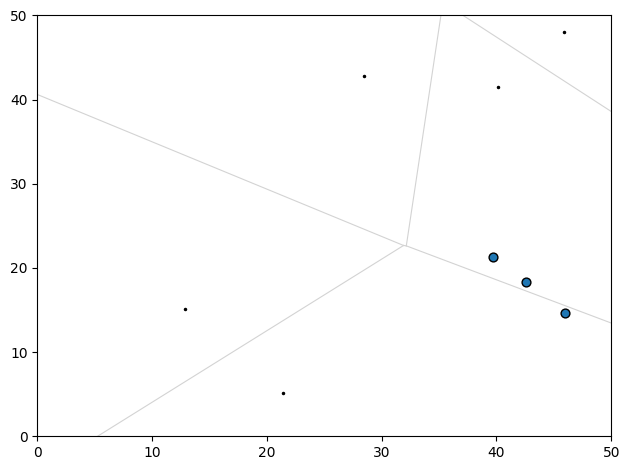

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.spatial import Voronoi
import numpy as np
from ross.environment.points_and_plane import Plane
from ross.agents.swarm import Swarm

# 1. Setup environment and swarm
plane = Plane(width=50, height=50, num_points=5)
swarm = Swarm(plane=plane, num_robots=10, sensing_radius=50.0)

# 2. Initialize robot paths after robots are created
robot_paths = [[] for _ in range(len(swarm.robots))]

# 3. Record initial positions
for i, bot in enumerate(swarm.robots):
    robot_paths[i].append(bot.get_position())

# 4. Step the simulation and record robot positions
def step_and_record():
    swarm.step()
    for i, bot in enumerate(swarm.robots):
        robot_paths[i].append(bot.get_position())

for _ in range(1000):
    step_and_record()

# 5. Plotting and animation
fig, ax = plt.subplots()
ax.set_xlim(0, plane.width)
ax.set_ylim(0, plane.height)

# 1. Get positions from the plane
points = plane.get_all_positions()
vor = Voronoi(points)

# 2. Plot finite and infinite Voronoi edges
center = points.mean(axis=0)
radius = np.ptp(points, axis=0).max() * 2

# Go through each Voronoi ridge
for pointidx, ridge_vertices in zip(vor.ridge_points, vor.ridge_vertices):
    ridge_vertices = np.asarray(ridge_vertices)
    if np.all(ridge_vertices >= 0):
        # Finite ridge: both vertices are defined
        p1, p2 = vor.vertices[ridge_vertices]
        ax.plot([p1[0], p2[0]], [p1[1], p2[1]], 'lightgray', lw=0.8, zorder=0)
    else:
        # Infinite ridge: construct a finite extension
        i = ridge_vertices[ridge_vertices >= 0][0]
        t = vor.points[pointidx[1]] - vor.points[pointidx[0]]  # tangent
        t /= np.linalg.norm(t)
        n = np.array([-t[1], t[0]])  # normal
        midpoint = vor.points[pointidx].mean(axis=0)
        direction = np.sign(np.dot(midpoint - center, n)) * n
        far_point = vor.vertices[i] + direction * radius
        ax.plot([vor.vertices[i, 0], far_point[0]],
                [vor.vertices[i, 1], far_point[1]],
                'lightgray', lw=0.8, zorder=0)

# Optional: show environment points
for x, y in plane.get_all_positions():
    ax.plot(x, y, 'k.', markersize=3)

# One dot per robot and one line for its trail
scatters = [ax.plot([], [], 'o')[0] for _ in swarm.robots]
trails = [ax.plot([], [], '-', linewidth=1)[0] for _ in swarm.robots]

def update(frame):
    for i in range(len(swarm.robots)):
        path = robot_paths[i][:frame+1]
        xdata, ydata = zip(*path)
        scatters[i].set_data([xdata[-1]], [ydata[-1]])  # Wrap in list
        trails[i].set_data(xdata, ydata)                # Path history
    return scatters + trails

ani = FuncAnimation(fig, update, frames=100, interval=100, blit=True)
plt.show()


In [ ]:

# 1. Compute final robot positions
final_positions = [path[-1] for path in robot_paths]
xs, ys = zip(*final_positions)

# 2. Make a fresh figure (or clear the old one)
fig2, ax2 = plt.subplots()
ax2.set_xlim(0, plane.width)
ax2.set_ylim(0, plane.height)

# 3. Re-plot the Voronoi diagram (same as before)
points = plane.get_all_positions()
vor = Voronoi(points)
center = points.mean(axis=0)
radius = np.ptp(points, axis=0).max() * 2
for pointidx, ridge_vertices in zip(vor.ridge_points, vor.ridge_vertices):
    ridge_vertices = np.asarray(ridge_vertices)
    if np.all(ridge_vertices >= 0):
        p1, p2 = vor.vertices[ridge_vertices]
        ax2.plot([p1[0], p2[0]], [p1[1], p2[1]],
                 'lightgray', lw=0.8, zorder=0)
    else:
        i = ridge_vertices[ridge_vertices >= 0][0]
        t = vor.points[pointidx[1]] - vor.points[pointidx[0]]
        t /= np.linalg.norm(t)
        n = np.array([-t[1], t[0]])
        midpoint = vor.points[pointidx].mean(axis=0)
        direction = np.sign(np.dot(midpoint - center, n)) * n
        far_point = vor.vertices[i] + direction * radius
        ax2.plot([vor.vertices[i, 0], far_point[0]],
                 [vor.vertices[i, 1], far_point[1]],
                 'lightgray', lw=0.8, zorder=0)

# 4. (Optional) plot the original random points
for x, y in points:
    ax2.plot(x, y, 'k.', markersize=3, zorder=1)

# 5. Plot final robot positions *without* any trails
ax2.scatter(xs, ys, s=40, c='C0', edgecolor='k', zorder=2)

# 6. Save it out
fig2.tight_layout()
fig2.savefig('final_frame.png', dpi=300)
